# Install Library

In [1]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install Sastrawi

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.util import ngrams

import re, string, unicodedata
import nltk
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.corpus import stopwords

import numpy as np
from sklearn.feature_selection import mutual_info_classif

import random
random.seed(42)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score

# Input Data

In [4]:
df =  pd.read_csv('Data/data_ulasan_pengguna_aplikasi_Vidio.csv')

In [5]:
sentiment_counts = df['Sentimen'].value_counts()
sentiment_counts

Negatif    3433
Positif    1237
Name: Sentimen, dtype: int64

# Text Preprocessing

In [6]:
kamus_alay = pd.read_excel('Data/Kamus_alay.xlsx', engine='openpyxl')
kamus_alay.columns = ['slang', 'formal']

In [7]:
alay_to_formal = dict(zip(kamus_alay.iloc[:, 0], kamus_alay.iloc[:, 1]))
def fix_alay_sentence(text, alay_dict):
    words = text.split()
    fixed_words = [alay_dict.get(word, word) for word in words]
    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [8]:
# Stopwords set
more_stopwords = ['ggs', 'ff', 'say', 'sy', 'sya', 'san', 'nya', 'nge', 'an', 'er']
stopwords_list = more_stopwords + nltk.corpus.stopwords.words('indonesian') + nltk.corpus.stopwords.words('english') + StopWordRemoverFactory().get_stop_words()
stopwords_list += [word.strip().lower() for word in pd.read_csv('https://raw.githubusercontent.com/irfandythalib/python-indonesia-stopwords-remover/refs/heads/main/tala-stopwords-indonesia.txt', header=None)[0]]
stopwords_list += [word.strip().lower() for word in pd.read_csv('https://raw.githubusercontent.com/SokKanaTorajd/indonesia-stopwords/refs/heads/main/indonesia-stopwords.txt', header=None)[0]]

words_to_exclude = ['oke', 'baik', 'tidak', 'guna', 'seru']

stopwords_set = set(stopwords_list) - set(words_to_exclude)

In [9]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [10]:
def preprocess_text(text):
    text = text.lower()  # Case folding
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  # Punctuation removal
    text = fix_alay_sentence(text, alay_to_formal)  # Normalization
    tokens = nltk.word_tokenize(text)  # Tokenization
    tokens = [stemmer.stem(token) for token in tokens]  # Stemming
    tokens = [token for token in tokens if token not in stopwords_set]  # Stopword removal
    return ' '.join(tokens)

df['preprocessed_text'] = df['Ulasan'].apply(preprocess_text)

In [11]:
# Replace empty values with NaN
df.replace([''], np.nan, inplace=True)

# Drop rows with NaN values in the 'stopwords' column
df_cleaned = df.dropna(subset=['preprocessed_text'])

# Save the cleaned DataFrame to Excel
df_cleaned[['Ulasan', 'preprocessed_text', 'Sentimen']].to_excel('Vidio_text_preprocessing.xlsx', index=False)

In [12]:
shuffled = df_cleaned.sample(frac=1, random_state=42).reset_index(drop=True)
X = shuffled['preprocessed_text']
y = shuffled['Sentimen']
X_1 = shuffled['Ulasan']
y_1 = shuffled['Sentimen']

In [13]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, random_state=42, test_size=0.2)

In [15]:
# Create a CountVectorizer object
count_vect = CountVectorizer()
# Fit the CountVectorizer on the training data
count_vect.fit(X_train)

CountVectorizer()

In [16]:
# Get all unique words 
word_list = count_vect.get_feature_names_out()

In [17]:
# Transform training and testing data using CountVectorizer
X_train_counts = count_vect.transform(X_train)
X_test_counts = count_vect.transform(X_test)

# CHI-SQUARE

In [18]:
# Create a DataFrame to store the word frequencies for each training review
word_freq_df_train = pd.DataFrame(X_train_counts.toarray(), columns=word_list)

In [19]:
# Add a column for the original review text from the training data
word_freq_df_train['Sentimen'] = y_1_train.values

In [20]:
def calculate_chi2(word, X_train, y_train, count_vect):
    word_index = count_vect.vocabulary_.get(word)
    a = np.sum((X_train_counts[y_train == 1][:, word_index] > 0), dtype = np.float64)
    b = np.sum((X_train_counts[y_train == 0][:, word_index] > 0), dtype = np.float64)
    c = np.sum((X_train_counts[y_train == 1][:, word_index] == 0), dtype = np.float64)
    d = np.sum((X_train_counts[y_train == 0][:, word_index] == 0), dtype = np.float64)
    n = len(y_train)
    chi2 = (n*(a*d - b*c)**2) / ((a+b) * (c+d) * (a+c) * (b+d))
    chi2_label = 'Positif'
    return chi2_label, a, b, c, d, chi2

In [21]:
results = []
for word in word_list:
    result = calculate_chi2(word, X_train, y_train, count_vect)
    results.append(result)

C:\Users\rheys\AppData\Local\Temp\ipykernel_4180\2427639161.py:3: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  result = calculate_chi2(word, X_train, y_train, count_vect)


In [22]:
# Create a DataFrame to store the results
columns = ['Chi2_label', 'A', 'B', 'C', 'D', 'Chi2']
df_chi2_positive = pd.DataFrame(results, columns = columns)
df_chi2_positive.insert(0, 'word', word_list)

# Sort the DataFrame by Chi2 in descending order
df_chi2_positive = df_chi2_positive.sort_values(by='Chi2', ascending=False)

In [23]:
def calculate_chi2(word, X_train, y_train, count_vect):
    word_index = count_vect.vocabulary_.get(word)
    a = np.sum((X_train_counts[y_train == 0][:, word_index] > 0), dtype = np.float64)
    b = np.sum((X_train_counts[y_train == 1][:, word_index] > 0), dtype = np.float64)
    c = np.sum((X_train_counts[y_train == 0][:, word_index] == 0), dtype = np.float64)
    d = np.sum((X_train_counts[y_train == 1][:, word_index] == 0), dtype = np.float64)
    n = len(y_train)
    chi2 = (n*(a*d - b*c)**2) / ((a+b) * (c+d) * (a+c) * (b+d))
    chi2_label = 'Negatif'
    return chi2_label, a, b, c, d, chi2

In [24]:
results = []
for word in word_list:
    result = calculate_chi2(word, X_train, y_train, count_vect)
    results.append(result)

C:\Users\rheys\AppData\Local\Temp\ipykernel_4180\2427639161.py:3: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  result = calculate_chi2(word, X_train, y_train, count_vect)


In [25]:
# Create a DataFrame to store the results
columns = ['Chi2_label', 'A', 'B', 'C', 'D', 'Chi2']
df_chi2_negative = pd.DataFrame(results, columns = columns)
df_chi2_negative.insert(0, 'word', word_list)

# Sort the DataFrame by Chi2 in descending order
df_chi2_negative = df_chi2_negative.sort_values(by='Chi2', ascending=False)

In [26]:
# Create DataFrame Chi2
df_chi2 = pd.DataFrame()
df_chi2['word'] = df_chi2_positive['word']
df_chi2['Chi2_positive'] = df_chi2_positive['Chi2']
df_chi2['Chi2_negative'] = df_chi2_negative['Chi2']
df_chi2['Chi2'] = df_chi2_positive['Chi2'] + df_chi2_negative['Chi2']

In [27]:
# Create a new DataFrame with the selected features for the train data
df_train_bow = pd.DataFrame(X_train_counts.toarray(), columns=word_list)
df_train_bow['target'] = y_train

In [28]:
# Select the top k features with the highest chi2 scores
k = 600
top_k_words = df_chi2['word'][:k].tolist()

In [29]:
# Create a new CountVectorizer with the selected features and fit it on the train data
count_vect_selected = CountVectorizer(vocabulary=top_k_words)
X_train_selected = count_vect_selected.fit_transform(X_train)

# Create a new DataFrame with the selected features for the train data
df_train_selected = pd.DataFrame(X_train_selected.toarray(), columns=top_k_words)

# Create a new CountVectorizer with the selected features and transform the test data
X_test_selected = count_vect_selected.transform(X_test)

# Create a new DataFrame with the selected features for the test data
df_test_selected = pd.DataFrame(X_test_selected.toarray(), columns=top_k_words)

## TF-IDF CHI-SQUARE

In [30]:
# Word Representation
# Create a TfidfVectorizer with the new vocabulary and fit it on the train data
vectorizer = TfidfVectorizer(vocabulary=top_k_words)
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the test data using the fitted vectorizer
X_test_tfidf = vectorizer.transform(X_test)

# Create a DataFrame to store the TF-IDF values for the train data
train_df_tfidf = pd.DataFrame(X_train_tfidf.toarray(), columns=top_k_words)

# Add the target variable to the train DataFrame
train_df_tfidf['target'] = y_train

# Create a DataFrame to store the TF-IDF values for the best data
test_df_tfidf = pd.DataFrame(X_test_tfidf.toarray(), columns=top_k_words)

# Add the target variable to the test DataFrame
test_df_tfidf['target'] = y_test

## SVM + CHI-SQUARE + TF-IDF

In [31]:
# SVM default mode
model = SVC()
model.fit(X_train_tfidf, y_train)

SVC()

In [32]:
# Predict the labels on the validation dataset
pred = model.predict(X_test_tfidf)

# Balanced accuracy score
balanced_accuracy_score(y_test, pred)

0.9363017934446506

# INFORMATION GAIN

In [33]:
# Calculate Information Gain for Count-Based Features
res = dict(zip(word_list, mutual_info_classif(X_train_counts, y_train, discrete_features=True)))

In [34]:
# Create a DataFrame from the information gain
res1 = pd.DataFrame.from_dict(res, orient='index', columns=['IG'])
res1 = res1.sort_values(by='IG', ascending=False)

In [35]:
# Select the top z features with the highest information gain scores
z = 600
top_z_words = res1.head(z).index.tolist()

In [36]:
# Create a new CountVectorizer with the selected features and fit it on the train data
count_vect_selected_ig = CountVectorizer(vocabulary=top_z_words)
X_train_selected_ig = count_vect_selected_ig.fit_transform(X_train)

# Create a new DataFrame with the selected features for the train data
df_train_selected_ig = pd.DataFrame(X_train_selected_ig.toarray(), columns=top_z_words)

# Create a new CountVectorizer with the selected features and transform the test data
X_test_selected_ig = count_vect_selected_ig.transform(X_test)

# Create a new DataFrame with the selected features for the test data
df_test_selected_ig = pd.DataFrame(X_test_selected_ig.toarray(), columns=top_z_words)

## TF-IDF IG

In [37]:
# Word Representation
# Create a TfidfVectorizer with the new vocabulary and fit it on the train data
vect = TfidfVectorizer(vocabulary=top_z_words)
X_train_tfidf_ig = vect.fit_transform(X_train)

# Transform the test data using the fitted vectorizer
X_test_tfidf_ig = vect.transform(X_test)

# Create a DataFrame to store the TF-IDF values for the train data
train_df_tfidf_ig = pd.DataFrame(X_train_tfidf_ig.toarray(), columns=top_z_words)

# Add the target variable to the train DataFrame
train_df_tfidf_ig['target'] = y_train

# Create a DataFrame to store the TF-IDF values for the test data
test_df_tfidf_ig = pd.DataFrame(X_test_tfidf_ig.toarray(), columns=top_z_words)

# Add the target variable to the test DataFrame
test_df_tfidf_ig['target'] = y_test

## SVM + IG + TF-IDF

In [38]:
# SVM default mode
model_ig = SVC()
model_ig.fit(X_train_tfidf_ig, y_train)

SVC()

In [39]:
# Predict the labels on the validation dataset
pred_ig = model_ig.predict(X_test_tfidf_ig)

# Balanced accuracy
balanced_accuracy_score(y_test, pred_ig)

0.8858777277144625

# THE MOST DISCUSSED TOPICS WITH NEGATIVE SENTIMENT

In [40]:
label_mapping = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))
result_predict = pd.DataFrame(X_1_test)
result_predict['actual_label'] = y_1_test
result_predict['predict_label'] = pred
result_predict['predict_label'] = result_predict['predict_label'].map(label_mapping)

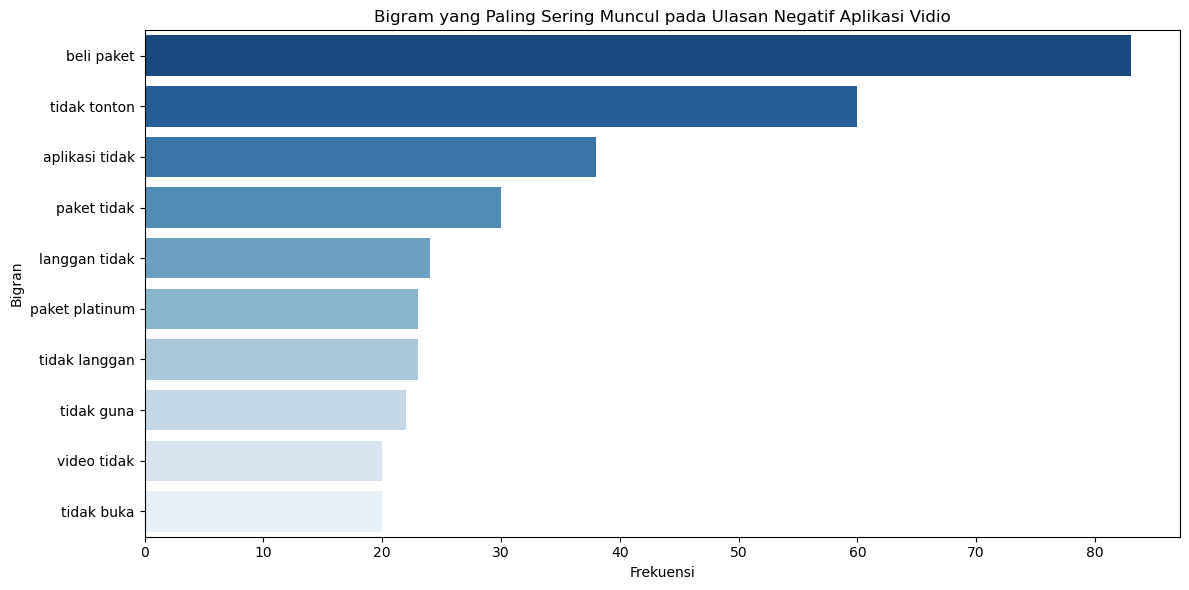

In [41]:
merged_data = pd.merge(result_predict, df_cleaned[['Ulasan', 'preprocessed_text']], on='Ulasan', how='left')

# Gabungkan semua token dari data negatif
negative_tokens = ' '.join(merged_data[merged_data['predict_label'] == 'Negatif']['preprocessed_text'].astype(str)).split()

# Hitung frekuensi n-gram (2 hingga 8)
all_ngrams = [gram for n in range(2, 9) for gram in ngrams(negative_tokens, n)]
top_ngrams = Counter(all_ngrams).most_common(10)

# Siapkan label dan frekuensi
df_topik = pd.DataFrame({
    'Topik': ['\n'.join([' '.join(gram[i:i+3]) for i in range(0, len(gram), 3)]) for gram, _ in top_ngrams],
    'Frekuensi': [freq for _, freq in top_ngrams]
})

# Visualisasi
plt.figure(figsize=(12, 6))
sns.barplot(x='Frekuensi', y='Topik', data=df_topik, palette='Blues_r')
plt.title("Bigram yang Paling Sering Muncul pada Ulasan Negatif Aplikasi Vidio")
plt.xlabel("Frekuensi")
plt.ylabel("Bigran")
plt.tight_layout()
plt.show()